# Obligatorio - Taller Agentes Inteligentes 2025

En este trabajo obligatorio aplicaremos los conceptos vistos en el curso para diseñar, implementar y evaluar agentes capaces de aprender a jugar al clásico **Breakout** de Atari, utilizando el entorno provisto por Farama Gymnasium ([https://ale.farama.org/environments/breakout/](https://ale.farama.org/environments/breakout/)). 

<p align="center">
  <img src="https://media.tenor.com/oMxHgRrISJsAAAAM/atari-deep-learning.gif" alt="Atari Deep Learning"/>
</p>


El ejercicio se enmarca en un contexto de aprendizaje práctico, donde trabajaremos con las interfaces estándar de Gymnasium para:

1. **Profundizar en algoritmos de valor**: implementaremos y compararemos dos variantes de Q-Learning basadas en redes neuronales profundas:
   * **Deep Q Learning (DQN)**
   * **Double Deep Q Learning (DDQN)**
2. **Evaluar rendimiento y estabilidad**: registraremos las recompensas obtenidas durante el entrenamiento de cada agente y analizaremos su comportamiento mediante gráficas comparativas.
3. **Demostrar resultados de forma visual**: capturaremos vídeos que muestren a cada agente “resolviendo” el entorno, entendido como la habilidad de romper al menos cinco bloques en una partida.

Debido a las limitaciones de tiempo y cómputo propias de un entorno de curso, no se espera entrenar modelos durante más de diez horas por agente. Por ello, será fundamental:

* Integrar puntos de **checkpoint** para guardar periódicamente los pesos de la red.
* Seguir en los puntos 2 y 3 la arquitectura y técnicas originales propuestas en los papers seminales de DQN y DDQN, dejando la experimentación adicional para el punto extra.
* Flexibilizar la notebook de guía: pueden reorganizarla o dividirla en múltiples archivos según su conveniencia.


## Objetivos y tareas

1. **Completar la implementación**
   * Rellenar el código faltante en la notebook y en los módulos auxiliares para que los agentes puedan interactuar con el entorno de Breakout.
2. **Entrenar agentes**
   * Ajustar y entrenar un **DQN** que alcance la condición de “resolver” (romper ≥ 10 bloques).
   * Ajustar y entrenar un **DDQN** con la misma meta de desempeño.
3. **Visualizar y analizar resultados**
   * Generar **gráficas comparativas** de las recompensas obtenidas por ambos agentes en el mismo entorno (una gráfica por ambiente). Además se sugiere gráficas que muestren el valor de la función de valor Q para cada agente.
   * Extraer **al menos dos conclusiones** por gráfica, comentando diferencias en convergencia, estabilidad y comportamiento exploratorio.
4. **Registro de demostraciones**
   * Grabar y entregar un **video demostrativo** de cada agente resolviendo el entorno.
5. **Experimentación**
   * Probar otras arquitecturas, técnicas de mejora o módulos de procesamiento de entradas más avanzados, documentando brevemente su impacto/

## Criterios de evaluación

| Criterio                                  | Descripción                                                  | Peso |
| ----------------------------------------- | ------------------------------------------------------------ | ---- |
| **Implementación y rendimiento**          | DQN y DDQN completados; cada agente rompe ≥ 10 bloques       | 40%  |
| **Estructura y narrativa de la notebook** | Secciones claras, explicación de decisiones, “historia”      | 20%  |
| **Análisis de resultados**                | Gráficas comparativas; ≥ 2 conclusiones por gráfico          | 20%  |
| **Presentación visual**                   | Vídeos demostrativos de cada agente                          | 10%  |
| **Experimentación**                       | Experimentación adicional documentada y analizada brevemente | 10%  |

## Bibliografía

* **Mnih, V.**, Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., … Hassabis, D. (2013). *Playing Atari with Deep Reinforcement Learning*. [arXiv:1312.5602](https://arxiv.org/abs/1312.5602)
* **van Hasselt, H.**, Guez, A., & Silver, D. (2015). *Deep Reinforcement Learning with Double Q-learning*. [arXiv:1509.06461](https://arxiv.org/abs/1509.06461)
* **Sutton, R. S.**, & Barto, A. G. (2018). *Reinforcement Learning: An Introduction* (2nd ed.), capítulo 16.5: “Human-level Video Game Play”. MIT Press.

# Import from github

In [18]:
# !git clone https://github.com/nataliacampiglia/obligatorio-taller-ia.git
# %cd obligatorio-taller-ia
# !git pull

## Setup

**Imports**

In [45]:
%load_ext autoreload
%autoreload 2
import os
import torch
import numpy as np
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import gymnasium
import ale_py
from utils import make_env, show_observation_stack, evaluate_training_phase_results
from IPython.display import Video


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ALE (Atari Learning Environment) es un entorno de aprendizaje para videojuegos de Atari. En este caso, utilizaremos el entorno de Breakout. Es necesario entender que se separa el entorno de los roms de Atari, que son los juegos en sí. El entorno de ALE permite interactuar con los juegos de Atari a través de una API estándar, facilitando la implementación de algoritmos de aprendizaje por refuerzo.

Debemos instalar los roms por separado, para ello primero tenemos que saber donde están los roms de Atari. 

In [2]:
gymnasium.register_envs(ale_py) # registramos todos los entornos de ale_py
ruta_init = ale_py.roms.__file__ # debemos saber donde se encuentra la carpeta roms
ALE_ROMS_PATH = os.path.dirname(ruta_init)
print(ALE_ROMS_PATH)

/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms


Podemos usar los siguientes comando para instalar los roms y colocalos en la carpeta correcta.

In [21]:
# !pip install "autorom[accept-rom-license]"
# !AutoROM --accept-license --install-dir {ALE_ROMS_PATH}

Fijamos la semilla para que los resultados sean reproducibles

In [3]:
SEED = 23

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic=True # https://discuss.pytorch.org/t/what-is-the-differenc-between-cudnn-deterministic-and-cudnn-benchmark/38054
torch.backends.cudnn.benchmark=True # https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936/4
np.random.seed(SEED)
random.seed(SEED)

Vemos que dispositivo tenemos, si es GPU, MPS o CPU. **El uso de GPU es altamente recomendable** para acelerar el entrenamiento de los modelos. 

In [4]:
# Algunas constantes

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS

print(f"Device: {DEVICE}")

Device: mps


## Preprocesando Atari

Para reproducir fielmente el enfoque de Mnih et al. (2013) y reducir la carga computacional al trabajar con imágenes de Atari (210 × 160 píxeles, 128 colores), aplicamos el siguiente preprocesado φ a las últimas **4** frames del entorno:

1. **Conversión a escala de grises**
   Eliminamos la información de color (GRAYSCALE = True), pues la luminosidad es suficiente para capturar la dinámica de juego y reduce drásticamente la dimensionalidad de la entrada.

2. **Down-sampling y recorte**
   * Redimensionamos la imagen original a 110 × 84 píxeles, manteniendo la proporción horizontal.
   * Recortamos un área central de 84 × 84 píxeles que contiene la “zona de juego”, descartando bordes innecesarios.
     Este paso (SCREEN_SIZE = 84) no solo concentra la atención del modelo en la región relevante, sino que también garantiza un tamaño cuadrado compatible con las implementaciones de convoluciones en GPU.

3. **Saltos temporales (frame skipping)**
   Procesamos cada 4 frames (SKIP_FRAMES = 4), repitiendo la misma acción durante esos pasos. Esto reduce la redundancia temporal, acelera el entrenamiento y mantiene la coherencia del movimiento de la paleta y la bola.

4. **Apilamiento de frames**
   Finalmente, acumulamos las últimas 4 imágenes preprocesadas (NUM_STACKED_FRAMES = 4) en un único tensor de entrada. Así el agente puede inferir la velocidad y dirección de los elementos móviles a partir de la diferencia entre frames.

Este esquema de preprocesado es fundamental para disminuir el espacio de entrada, acelerar las convoluciones y proporcionar al Q-net una representación compacta y rica en información dinámica, tal como se describe en el algoritmo 1 del paper original .

> Se recomienda ver el método `make_env` en el archivo `utils.py` para entender cómo se implementa este preprocesado. 

In [5]:
GRAY_SCALE = True # si True, convertimos la imagen a escala de grises
SCREEN_SIZE = 84 # redimensionamos a SCREEN_SIZExSCREEN_SIZE
NUM_STACKED_FRAMES = 4 # apilamos NUM_STACKED_FRAMES frames
SKIP_FRAMES = 4 # saltamos SKIP_FRAMES frames (haciendo la misma acción)
ENV_NAME = "ALE/Breakout-v5" 

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 390062766
/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/reichelort/Desktop/Taller_AI/Obligatorio final/obligatorio-taller-ia/videos/random folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


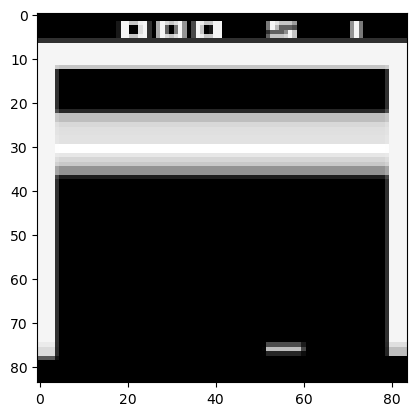

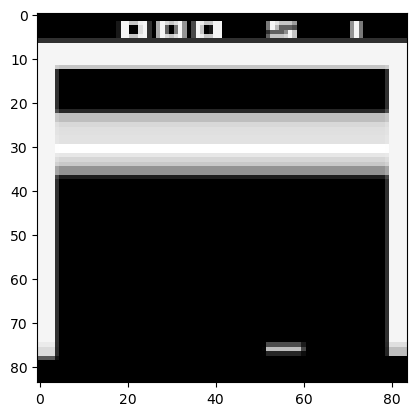

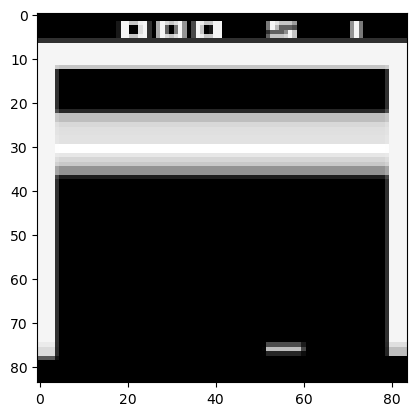

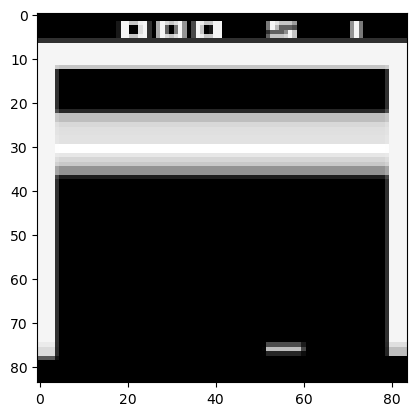

Episode 1 finished with total reward: 0


In [14]:
# https://ale.farama.org/environments/breakout/
ENV_NAME = "ALE/Breakout-v5" 

env = make_env(ENV_NAME,
                video_folder='./videos/random',
                name_prefix="breakout",
                record_every=1,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

for episode_num in range(1):
    obs, info = env.reset()
    show_observation_stack(obs)
    reward_total = 0
    episode_over = False
    while not episode_over:
        action = env.action_space.sample()  # seleccionamos una acción aleatoria
        obs, reward, terminated, truncated, info = env.step(action)
        reward_total += reward
        episode_over = terminated or truncated
    print(f"Episode {episode_num + 1} finished with total reward: {reward_total}")

env.close()

Además, podemos mostrar los videos capturados por el entorno de Atari de la siguiente manera:

In [13]:
# Ruta al archivo de vídeo en tu sistema de ficheros
video_path = "./videos/random/breakout-episode-0.mp4"

# Muestra el vídeo
Video(video_path, embed=True, width=600)

# Exploración del entorno

In [ ]:
print("Actions shape:",env.action_space)
print("Observation shape:",env.observation_space.shape)
env.reset()
next_state, reward, terminated, truncated, info = env.step(action=0)

print(f"{next_state.shape},\n {reward},\n {terminated},\n {info}")

### Acciones
...

### Observaciones
...

# Deep Q Learning

Deep Q Learning extiende el algoritmo clásico de Q-learning al emplear una **red neuronal profunda** como aproximador de la función de valor $Q(s,a)$. Inspirado en Mnih et al. (2013), este método utiliza una **red convolucional** para procesar directamente las imágenes del entorno Atari, un **replay buffer** para romper la correlación temporal de las muestras. La política sigue un esquema **ε-greedy**, balanceando exploración y explotación, y se entrena minimizando el error de la ecuación de Bellman sobre lotes de transiciones muestreadas de manera aleatoria.

<p align="center">
  <img src="https://www.researchgate.net/profile/Faris-Mismar/publication/327045314/figure/fig4/AS:819677282455553@1572437701142/Structure-of-the-neural-network-used-for-the-Deep-Q-learning-Network-implementation-with.png" alt="DQN"/>
</p>

Fuente: [arXiv:1312.5602](https://arxiv.org/abs/1312.5602)

## Memoria

El algoritmo de Deep Q Learning presentado en el paper utiliza una memoria (llamada Replay Memory) para almacenar transiciones pasadas. Tuplas que contienen un estado base, la accion tomada, la recompensa obtenida, una bandera que indica si el siguiente estado es final o no; y el estado siguiente.

Esta memoria es circular, es decir, tiene un límite maximo de elementos y una vez esté llena comienza a reemplazar los elementos más viejos.

Vamos a necesitar crear una función **sample** que obtiene una mustra aleatoria de elementos de la memoria.  Esto puede ser una lista de Transiciones o listas separadas (pero alineadas) de los elementos que las componen.


> Para implementar esta funcionalidad se debe modificar el archivo **replay_memory.py**

In [ ]:
# from replay_memory import ReplayMemory, Transition

# # Creamos la memoria de repetición
# replay_memory = ReplayMemory(3)

# # Añadimos transiciones a la memoria (solo las 3 últimas se guardan)
# replay_memory.add('state1', 'action1', 'reward1', 'done1', 'next_state1' )
# replay_memory.add('state2', 'action2', 'reward2', 'done2', 'next_state2')
# replay_memory.add('state3', 'action3', 'reward3', 'done3', 'next_state3')
# replay_memory.add('state4', 'action4', 'reward4', 'done4', 'next_state4')

# # Mostramos el tamaño de la memoria
# print(f"Memory size: {len(replay_memory)}\n")

# Mostramos un sample de la memoria
# sampled = replay_memory.sample(2)
# print(f"Memory sample:")
# for i, sample in enumerate(sampled):
#     print(f"Sample {i}: {sample}")


## Modelo

Vamos a usar un mismo modelo FeedForward para estos dos problemas (entrenado en cada problema particular). Recomendamos simplicidad en la creación del mismo, pero tienen total libertad al momento de implementarlo.

> Para implementar esta funcionalidad se debe modificar el archivo **dqn_cnn_model.py**. Se recomienda empezar por una arquitectura simple como la que se muestra en el paper de Mnih et al. (2013) y luego experimentar con arquitecturas más complejas.

In [15]:
from dqn_cnn_model import DQN_CNN_Model

env = make_env(ENV_NAME,
                record_every=None,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )
print("Actions shape:",env.action_space)
print("Observatiion shape:",env.observation_space.shape)

env.close()

cnn_model = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)
summary(cnn_model, input_size=(32, SKIP_FRAMES, SCREEN_SIZE, SCREEN_SIZE), device=DEVICE) # 32 es el batch size

Actions shape: Discrete(4)
Observatiion shape: (4, 84, 84)


A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 1427192884
/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:416: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


Layer (type:depth-idx)                   Output Shape              Param #
DQN_CNN_Model                            [32, 4]                   --
├─Conv2d: 1-1                            [32, 16, 20, 20]          4,112
├─Conv2d: 1-2                            [32, 32, 9, 9]            8,224
├─Linear: 1-3                            [32, 256]                 663,808
├─Linear: 1-4                            [32, 4]                   1,028
Total params: 677,172
Trainable params: 677,172
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 95.22
Input size (MB): 3.61
Forward/backward pass size (MB): 2.37
Params size (MB): 2.71
Estimated Total Size (MB): 8.69

La red esta definida para que reciba un tensor de 4 dimensiones (batch_size, num_frames, height, width) y devuelve un tensor de 2 dimensiones (batch_size, num_actions). La función `forward` es la encargada de definir el flujo de datos a través de la red. En este caso, se utiliza una red convolucional seguida de capas totalmente conectadas

In [16]:
obs_tensor_batch = torch.rand((NUM_STACKED_FRAMES,SCREEN_SIZE,SCREEN_SIZE)).unsqueeze(0).to(DEVICE) # Añadimos una dimensión para el batch y lo pasamos al dispositivo
print(f"Q-values shape: {cnn_model(obs_tensor_batch).shape}") # shape: (1, num_actions) 

Q-values shape: torch.Size([1, 4])


Los valores de Q se obtienen a partir de la salida de la red, cada columna representa el valor Q para cada acción posible en el estado actual. 

In [17]:
cnn_model(obs_tensor_batch) 

tensor([[-0.0188,  0.0008,  0.0328,  0.0380]], device='mps:0',
       grad_fn=<LinearBackward0>)

Podemos preguntar cuál es la acción con mayor valor Q en un estado.

In [18]:
cnn_model(obs_tensor_batch).max(1)

torch.return_types.max(
values=tensor([0.0380], device='mps:0', grad_fn=<MaxBackward0>),
indices=tensor([3], device='mps:0'))

En el siguiente ejemplo vamos a ver cómo tomar los valores de acciones deseables para un conjunto de estados. 

In [19]:
# Creamos 3 observaciones aleatorias para probar el modelo
obs_ran1 = torch.rand(4, 84, 84)
obs_ran2 = torch.rand(4, 84, 84)
obs_ran3 = torch.rand(4, 84, 84)

batch = torch.stack([obs_ran1, obs_ran2, obs_ran3], dim=0).to(DEVICE) # shape: (3, 4, 84, 84)
print(f"Batch shape: {batch.shape}")

actions =  torch.tensor([1, 2, 3], device=DEVICE).unsqueeze(1) # queremos la acción 1 para la primera observación, la acción 2 para la segunda y la acción 3 para la tercera

Q_test = cnn_model(batch)
print(f"Q-values: {Q_test}")
print(f"Q-values: {Q_test.gather(1, actions)}") # https://pytorch.org/docs/main/generated/torch.gather.html

Batch shape: torch.Size([3, 4, 84, 84])
Q-values: tensor([[-0.0399,  0.0014,  0.0332,  0.0316],
        [-0.0319,  0.0112,  0.0292,  0.0156],
        [-0.0356,  0.0033,  0.0296,  0.0224]], device='mps:0',
       grad_fn=<LinearBackward0>)
Q-values: tensor([[0.0014],
        [0.0292],
        [0.0224]], device='mps:0', grad_fn=<GatherBackward0>)


## Phi 

La función para procesar los estados (phi en el paper) que es necesaria para poder usar el modelo de Pytorch con las representaciones de gym. Esta función pasa una observación de gym a un tensor de Pytorch y la normaliza.

> Técnicamente la función phi tiene más responsabilidades, como la de apilar los frames y el downsampling. En nuestro caso se lo delegamos a los wrappers de gymnasium.

In [12]:
def process_state(obs):
    """
    Preprocess the state to be used as input for the model (transform to tensor).
    """
    return torch.tensor(obs, dtype=torch.float32, device=DEVICE) / 255.0

# obs, _ = env.reset()
# obs_tensor = process_state(obs)
# print(f"Observation shape: {obs_tensor.shape}")

## Agente

Vamos a definir una clase agente (abstracto), encargado de interactuar con el ambiente y entrenar los modelos. Los métdos definidos deben funcionar para ambos problemas simplemente cambiando el modelo a utilizar para cada ambiente.

Abajo dejamos un esqueleto del mismo y las funciones a completar. Recomendamos no alterar la estructura del mismo, pero pueden definir las funciones auxiliares que consideren necesarias.

> Para implementar esta funcionalidad se debe modificar los archivos **abstract_agent.py** y **dqn_agent.py**.

Funciones a completar:


1. **init**: que inicializa los parametros del agente.

2. **compute_epsilon**: que computa el valor actual de epsilon en base al número de pasos actuales y si esta entrenando o no.

3. **select_action**: Seleccionando acciones "epsilongreedy-mente" si estamos entranando y completamente greedy en otro caso.

4. **train**: que entrena el agente por un número dado de episodios de largo determinado.

5. **record_test_episode**: para grabar un episodio con el agente siempre seleccionando la mejor accion conocida.

## Entrenamiento

# Entrenamiento Progresivo de un Agente DQN en Breakout

En esta sección del obligatorio implementamos un agente basado en Deep Q-Network (DQN) para resolver el entorno **Breakout** de Atari.

El objetivo es demostrar progresivamente cómo el agente mejora su rendimiento a través de fases de entrenamiento, visualización de métricas y evaluación.

## 1. Preparación del entorno y del agente

Comenzamos creando el entorno y nuestro agente DQN, basado en una red convolucional. Definimos los hiperparámetros iniciales que guiarán su comportamiento durante el entrenamiento.

Este paso es como presentar a nuestro protagonista antes de su viaje.

### Hiperparámetros fijos durante todo el entrenamiento

In [12]:
BATCH_SIZE = 32
BUFFER_SIZE = 30_000
EPISODE_BLOCK = 100
LEARNING_RATE = 1e-5
STEPS_PER_EPISODE = 20_000
GAMMA = 0.995

### Hiperparámetros variables durante el entrenamiento

In [13]:
TOTAL_STEPS = 100_000
EPISODES = 10_000
EPSILON_INI = 1
EPSILON_MIN = 0.3
EPSILON_ANNEAL_STEPS = 80_000


### Creamos función global que ejecuta la fase de entrenamiento específica

In [22]:
%load_ext autoreload
%autoreload 2
import importlib
import replay_memory  # or whatever module you changed
import dqn_cnn_model
import dqn_agent
import abstract_agent
import torch
importlib.reload(replay_memory)
importlib.reload(dqn_cnn_model)
importlib.reload(dqn_agent)
importlib.reload(abstract_agent)
from dqn_cnn_model import DQN_CNN_Model
from dqn_agent import DQNAgent

def execute_dqn_training_phase(phase_name, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_ini = EPSILON_INI, epsilon_min = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS):
    env = make_env(ENV_NAME,
                video_folder=f'./videos/DQN/{phase_name}',
                name_prefix="breakout",
                record_every=500,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )
    net = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)
    dqn_agent = DQNAgent(env, net, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i=epsilon_ini, epsilon_f=epsilon_min, epsilon_anneal_steps=epsilon_anneal_steps, episode_block=EPISODE_BLOCK, device=DEVICE, run_name=phase_name)
    dqn_rewards = dqn_agent.train(episodes, STEPS_PER_EPISODE, total_steps)

env.close()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Creamos el entorno

In [16]:
env = make_env(ENV_NAME,
                video_folder='./videos/dqn_training-initial',
                name_prefix="breakout",
                record_every=500,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -1332839434
/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/reichelort/Desktop/Taller_AI/Obligatorio final/obligatorio-taller-ia/videos/dqn_training-initial folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


## 2. Primeros pasos de aprendizaje

En esta etapa inicial, el agente comienza su proceso de entrenamiento enfrentándose al entorno por primera vez. Ejecutamos un bloque limitado a **100.000 pasos**, con el objetivo principal de que el agente **explore intensamente** en lugar de tratar de maximizar recompensas desde el principio.

Para fomentar esta exploración, configuramos el parámetro `epsilon` —que controla la probabilidad de tomar acciones aleatorias— con los siguientes valores:

- `EPSILON_INI = 1.0`: al inicio, el agente toma decisiones completamente al azar.
- `EPSILON_MIN = 0.3`: al final del bloque, aún mantiene un 30% de exploración para evitar caer en políticas subóptimas demasiado pronto.

Este enfoque permite que el agente **cometa errores**, **pruebe diferentes estrategias** y **recolecte una variedad de experiencias** útiles que luego serán aprovechadas durante el entrenamiento.

En esta fase **no esperamos que el agente sea bueno todavía**. De hecho, probablemente falle con frecuencia. Sin embargo, es aquí donde empieza a identificar patrones básicos del entorno —como la relación entre sus acciones y las recompensas—, sentando las bases para mejorar en etapas posteriores.

In [1]:
%load_ext autoreload
%autoreload 2
import importlib
import replay_memory  # or whatever module you changed
import dqn_cnn_model
import dqn_agent
import abstract_agent
import torch
importlib.reload(replay_memory)
importlib.reload(dqn_cnn_model)
importlib.reload(dqn_agent)
importlib.reload(abstract_agent)
from dqn_cnn_model import DQN_CNN_Model
from dqn_agent import DQNAgent

from abstract_agent import Agent

### Creamos la policy_net

In [33]:
net = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)

### Inicializamos el DQN Agent

In [34]:
dqn_agent = DQNAgent(env, net, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i=EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_steps=EPSILON_ANNEAL_STEPS, episode_block=EPISODE_BLOCK, device=DEVICE, run_name="initial_run")

In [35]:
dqn_rewards = dqn_agent.train(EPISODES, STEPS_PER_EPISODE, TOTAL_STEPS)

env.close()

Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]

Iniciando entrenamiento...


Entrenando:   5%|▌         | 500/10000 [18:59<6:00:51,  2.28s/episode, reward=1.7, epsilon=0.3, steps=1e+5]    

Entrenamiento detenido: se alcanzaron 100001 pasos.


### Visualizar métricas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


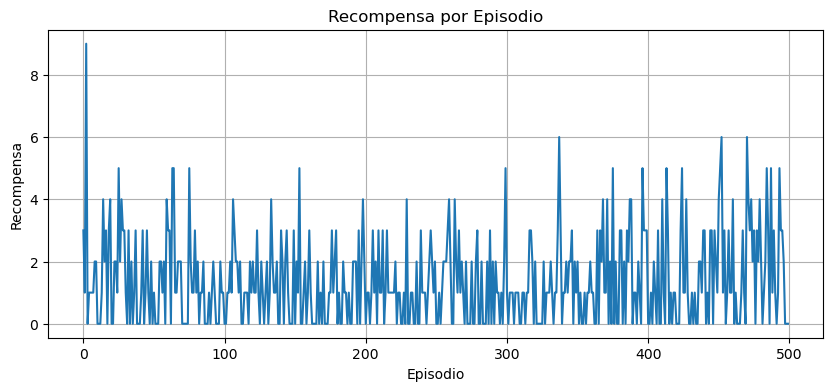

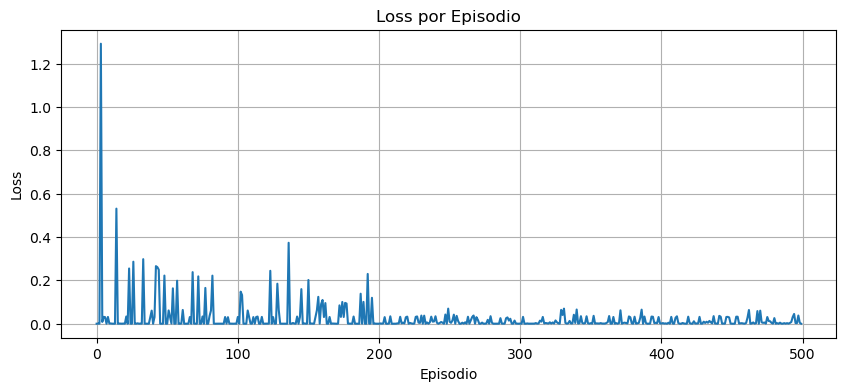

In [37]:
%load_ext autoreload
%autoreload 2
from utils import graph_metrics

graph_metrics(pathname="metrics/metrics_initial_run.npz")

## 3. Fase 2 de entrenamiento: Aprendizaje básico

Luego de la exploración inicial, el agente ya ha tenido contacto con el entorno y comenzó a identificar patrones básicos de acción y recompensa. En esta segunda fase, extendemos el entrenamiento a **500.000 pasos**, con el objetivo de que el agente comience a **refinar sus decisiones** y desarrolle políticas más efectivas.

En esta etapa ya no se explora al azar completamente. En cambio, **se busca un balance entre exploración y explotación**: permitir al agente seguir probando nuevas acciones, pero también comenzar a confiar más en lo que ha aprendido.

Por eso, ajustamos el parámetro `epsilon` de la siguiente manera:

- `EPSILON_INI = 0.3`: el agente ya no actúa completamente al azar, pero aún explora activamente.
- `EPSILON_MIN = 0.05`: al final del bloque, la exploración se reduce significativamente, permitiendo una mayor explotación.
- `EPSILON_ANNEAL_STEPS = 300_000`: la reducción se hace de forma gradual durante la mayor parte del bloque.

Durante esta fase, **esperamos observar una mejora clara en el rendimiento**:
- Aumento progresivo en la recompensa media.
- Episodios más largos (el agente sobrevive más).
- Menor pérdida (loss), reflejando una mejor aproximación de los valores Q.

Esta fase es clave para que el agente **consolide lo aprendido** y empiece a mostrar un comportamiento más coherente, orientado a maximizar la recompensa.

In [49]:
TOTAL_STEPS = 500_000
EPISODES = 10_000
EPSILON_INI = 0.3
EPSILON_MIN = 0.05
EPSILON_ANNEAL_STEPS = 300_000

In [50]:
env = make_env(ENV_NAME,
                video_folder='./videos/dqn_training_phase2',
                name_prefix="breakout",
                record_every=500,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -292690463
/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/reichelort/Desktop/Taller_AI/Obligatorio final/obligatorio-taller-ia/videos/dqn_training_phase2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:416: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.w

In [51]:
net = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)

In [52]:
net.load_state_dict(torch.load("net_history/GenericDQNAgent-run:initial_run-steps:100001-e:0.3000-max_r:1.7.dat"))

FileNotFoundError: [Errno 2] No such file or directory: 'net_history/GenericDQNAgent-run:initial_run-steps:100001-e:0.3000-max_r:1.7.dat'

In [ ]:
dqn_agent = DQNAgent(env, net, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i=EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_steps=EPSILON_ANNEAL_STEPS, episode_block=EPISODE_BLOCK, device=DEVICE, run_name="phase2_run")

In [ ]:
dqn_rewards = dqn_agent.train(EPISODES, STEPS_PER_EPISODE, TOTAL_STEPS)

env.close()

Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]

Iniciando entrenamiento...


/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:  20%|██        | 2049/10000 [1:34:18<6:05:59,  2.76s/episode, reward=4.01, epsilon=0.05, steps=5e+5]   

Entrenamiento detenido: se alcanzaron 500001 pasos.
Checkpoint guardado en GenericDQNAgent-steps:500001-e:0.05.dat


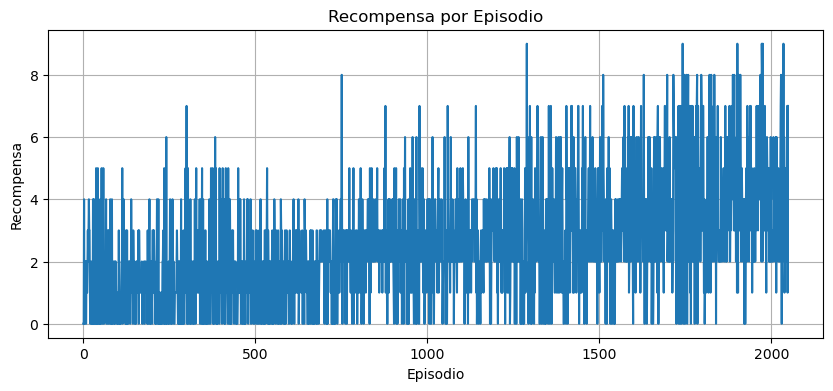

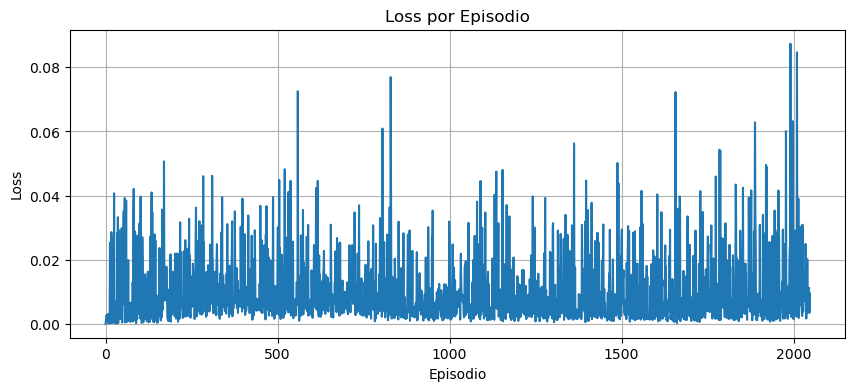

In [ ]:
graph_metrics(pathname="metrics/metrics_phase2_run.npz")

### Evaluamos el progreso del agente

In [ ]:
env = make_env(ENV_NAME,
                video_folder='./videos/dqn_validation/phase2',
                name_prefix="breakout",
                record_every=1,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 1393104993


In [ ]:
dqn_agent.play(env, episodes=1)

env.close()

In [ ]:
env = make_env(ENV_NAME,
                video_folder='./videos/dqn_validation-2',
                name_prefix="breakout",
                record_every=1,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )



A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 339480332


In [ ]:
dqn_agent.play(env, episodes=1)

env.close()

In [ ]:
# Ruta al archivo de vídeo en tu sistema de ficheros
video_path = "./videos/dqn_validation/phase2/breakout-episode-0.mp4"

# Muestra el vídeo
Video(video_path, embed=True, width=600)

## 4. Consolidación y estabilidad de la política

Después de haber explorado el entorno y refinado algunas estrategias efectivas, el agente ya no actúa completamente a ciegas. Ha empezado a desarrollar comportamientos útiles, y ahora es momento de **consolidar** ese conocimiento.

En esta tercera fase, extendemos el entrenamiento a **2.000.000 de pasos**, lo que permite al agente mejorar la consistencia de sus decisiones y adaptarse mejor a situaciones complejas del entorno.

En esta etapa, la exploración es mucho más moderada. El agente debe confiar cada vez más en su política aprendida, pero aún se le permite cierta libertad para seguir ajustando su comportamiento.

Configuramos el parámetro `epsilon` así:

- `EPSILON_INI = 0.1`: partimos de una exploración baja, porque el agente ya tiene una base aprendida.
- `EPSILON_MIN = 0.01`: dejamos una pequeña ventana de exploración por si aún puede descubrir mejores acciones.
- `EPSILON_ANNEAL_STEPS = 1.000.000`: el `epsilon` decae lentamente, permitiendo una transición gradual hacia la explotación.

Durante esta fase **esperamos observar mejoras más claras y sostenidas** en las métricas:
- La recompensa promedio por episodio debería aumentar.
- El `loss` debería estabilizarse en valores más bajos y menos ruidosos.
- El número de pasos por episodio debería incrementarse, señal de que el agente sobrevive y actúa con mayor efectividad.

Esta fase marca el paso de un comportamiento inestable a una política más **madura y confiable**, donde el agente deja de aprender por prueba y error, y empieza a actuar con intención.

In [50]:
TOTAL_STEPS = 2_000_000
EPISODES = 10_000
EPSILON_INI = 0.1
EPSILON_MIN = 0.01
EPSILON_ANNEAL_STEPS = 1_000_000

In [51]:
env = make_env(ENV_NAME,
                video_folder='./videos/dqn_training_phase3',
                name_prefix="breakout",
                record_every=500,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -196329338


In [52]:
net.load_state_dict(torch.load("net_history/GenericDQNAgent-run:phase2_run-steps:500001-e:0.0500-max_r:4.01.dat"))

<All keys matched successfully>

In [53]:
dqn_agent = DQNAgent(env, net, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i=EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_steps=EPSILON_ANNEAL_STEPS, episode_block=EPISODE_BLOCK, device=DEVICE, run_name="phase3_run")

In [54]:
dqn_rewards = dqn_agent.train(EPISODES, STEPS_PER_EPISODE, TOTAL_STEPS)

env.close()

Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]

Iniciando entrenamiento...


/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:  15%|█▌        | 1500/10000 [1:38:21<9:33:11,  4.05s/episode, reward=6.63, epsilon=0.055, steps=5e+5]    

Checkpoint guardado en GenericDQNAgent-steps:500244-e:0.05497804.dat


Entrenando:  27%|██▋       | 2724/10000 [3:16:22<12:09:10,  6.01s/episode, reward=8.84, epsilon=0.01, steps=1e+6]    

Checkpoint guardado en GenericDQNAgent-steps:1000300-e:0.01.dat


Entrenando:  37%|███▋      | 3695/10000 [4:54:33<10:53:27,  6.22s/episode, reward=9.94, epsilon=0.01, steps=1.5e+6] 

Checkpoint guardado en GenericDQNAgent-steps:1500270-e:0.01.dat


Entrenando:  46%|████▌     | 4593/10000 [6:32:47<7:42:24,  5.13s/episode, reward=12.1, epsilon=0.01, steps=2e+6]    

Entrenamiento detenido: se alcanzaron 2000001 pasos.
Checkpoint guardado en GenericDQNAgent-steps:2000001-e:0.01.dat


In [ ]:
net.load_state_dict(torch.load("net_history/GenericDQNAgent-run:phase2_run-steps:500001-e:0.0500-max_r:4.01.dat"))

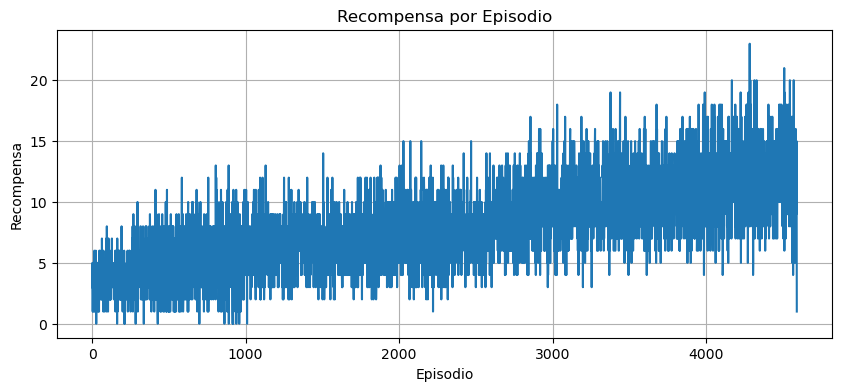

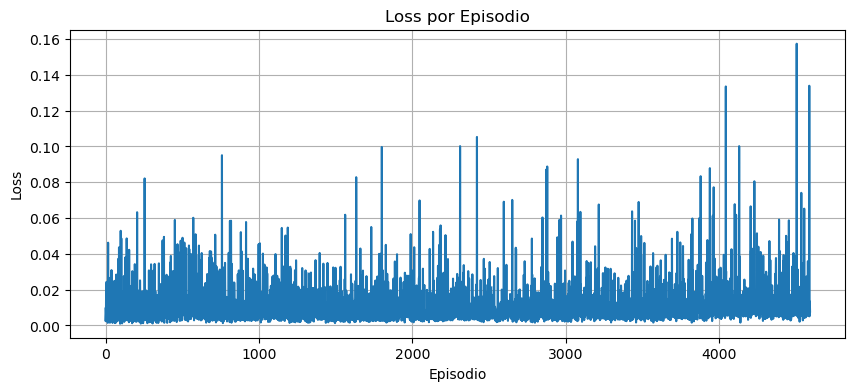

In [55]:
graph_metrics(pathname="metrics/metrics_phase3_run.npz")

### Evaluar el juego del ambiente

In [56]:
env = make_env(ENV_NAME,
                video_folder='./videos/dqn_validation/phase3',
                name_prefix="breakout",
                record_every=1,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -1028027523


In [57]:
dqn_agent.play(env, episodes=1)

env.close()

In [58]:
# Ruta al archivo de vídeo en tu sistema de ficheros
video_path = "./videos/dqn_validation/phase3/breakout-episode-0.mp4"

# Muestra el vídeo
Video(video_path, embed=True, width=600)

## 5. Entrenamiento largo

Luego de consolidar una política estable, el agente está listo para enfrentar su fase más extensa: **un entrenamiento de 7.000.000 pasos**. Esta etapa tiene como objetivo principal **refinar los últimos detalles de su comportamiento**, buscando alcanzar un rendimiento óptimo y robusto.

En cuanto al epsilon, mantenemos un valor inicial muy bajo para promover una política estable, pero sin eliminar por completo la posibilidad de explorar si se presenta algo poco frecuente:

- `EPSILON_INI = 0.05`: el agente comienza confiando casi por completo en su política aprendida.
- `EPSILON_MIN = 0.01`: se conserva un margen muy pequeño de exploración para evitar caer en políticas rígidas o locales.
- `EPSILON_ANNEAL_STEPS = 1.000.000`: el descenso es lento y progresivo, asegurando una transición estable hacia la explotación total.

En este punto, el agente ya sabe jugar razonablemente bien. El objetivo no es descubrir nuevas estrategias, sino **mejorar la consistencia, evitar errores esporádicos** y adaptarse a variaciones sutiles del entorno.

En la gráfica de pérdida (loss), esperamos observar:

- Valores bajos de pérdida sostenida, con menor varianza.
- Posibles picos aislados, que reflejan casos complejos o poco frecuentes.
- Una mayor proporción de episodios con `loss` cercano a cero.

Esta etapa representa el momento en que el agente deja de aprender con grandes saltos y empieza a **pulir detalles**, como quien afina los últimos toques antes de una presentación.

Al final de esta fase, esperamos ver un comportamiento mucho más **confiado, efectivo y repetible**, listo para ser evaluado sin exploración y con resultados competitivos.

In [15]:
TOTAL_STEPS = 2_000_000
EPISODES = 10_000
EPSILON_INI = 0.01
EPSILON_MIN = 0.01
EPSILON_ANNEAL_STEPS = 1_000_000

In [16]:
env = make_env(ENV_NAME,
                video_folder='./videos/dqn_training_phase4',
                name_prefix="breakout",
                record_every=500,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -38645947
/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/reichelort/Desktop/Taller_AI/Obligatorio final/obligatorio-taller-ia/videos/dqn_training_phase4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [18]:
net = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)

In [19]:
# net.load_state_dict(torch.load("net_history/GenericDQNAgent-run:phase3_run-steps:2000001-e:0.0100-max_r:12.05.dat"))
net.load_state_dict(torch.load("net_history/GenericDQNAgent-run:phase4_run-steps:3000344-e:0.0100-max_r:14.99.dat"))

<All keys matched successfully>

In [22]:
dqn_agent = DQNAgent(env, net, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i=EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_steps=EPSILON_ANNEAL_STEPS, episode_block=EPISODE_BLOCK, device=DEVICE, run_name="phase4_run")

In [23]:
dqn_rewards = dqn_agent.train(EPISODES, STEPS_PER_EPISODE, TOTAL_STEPS)

env.close()

Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]

Iniciando entrenamiento...


/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   8%|▊         | 760/10000 [2:04:07<23:23:06,  9.11s/episode, reward=15.3, epsilon=0.01, steps=5e+5]  

Checkpoint guardado en GenericDQNAgent-steps:500011-e:0.01.dat


Entrenando:  15%|█▌        | 1505/10000 [4:10:30<26:14:19, 11.12s/episode, reward=13.8, epsilon=0.01, steps=1e+6]  

Checkpoint guardado en GenericDQNAgent-steps:1000089-e:0.01.dat


Entrenando:  15%|█▌        | 1515/10000 [4:12:24<23:33:39, 10.00s/episode, reward=14, epsilon=0.01, steps=1006190]


KeyboardInterrupt: 

In [24]:
net.load_state_dict(torch.load("net_history/GenericDQNAgent-run:phase4_run-steps:1000089-e:0.0100-max_r:13.85.dat"))

<All keys matched successfully>

In [10]:
env = make_env(ENV_NAME,
                video_folder='./videos/dqn_validation/phase4-2',
                name_prefix="breakout",
                record_every=1,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 169026850
/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/reichelort/Desktop/Taller_AI/Obligatorio final/obligatorio-taller-ia/videos/dqn_validation/phase4-2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [27]:
dqn_agent.play(env, episodes=1)

env.close()

In [66]:
# Ruta al archivo de vídeo en tu sistema de ficheros
video_path = "./videos/dqn_validation/phase4/breakout-episode-0.mp4"

# Muestra el vídeo
Video(video_path, embed=True, width=600)

#### Graficas 
...

# Double Deep Q Learning

Double DQN mejora la versión clásica de DQN corrigiendo el sesgo de sobreestimación de los valores 
𝑄
Q. Para ello, desacopla la selección de la acción de su evaluación: en cada paso, la red online elige la acción que maximiza 
𝑄
Q, pero la red objetivo distinta estima el valor de esa acción. Esta separación reduce el sesgo hacia valores demasiado optimistas y aporta mayor estabilidad al entrenamiento. El resto de la estructura —replay buffer, política ε-greedy, etc— se mantiene igual que en DQN, aprovechando así un diseño casi idéntico al original pero con resultados más fiables .

Fuente: [arXiv:1509.06461](https://arxiv.org/abs/1509.06461)

> Vamos a utilizar el mismo modelo de red neuronal creado para el problema anterior y la misma implementación de memoria, dejamos un esqueleto de un agente de Double Deep Q learning para completar en el archivo **double_dqn_agent.py**

# Entrenamiento Progresivo de un Agente DDQN en Breakout

En esta sección del obligatorio implementamos un agente basado en Double Deep Q-Network (DQN) para resolver el entorno **Breakout** de Atari.

El objetivo es demostrar progresivamente cómo el agente mejora su rendimiento a través de fases de entrenamiento, visualización de métricas y evaluación.

## 1. Preparación del entorno y del agente

Comenzamos creando el entorno y nuestro agente DDQN, basado en una red convolucional. Definimos los hiperparámetros iniciales que guiarán su comportamiento durante el entrenamiento.

Este paso es como presentar a nuestro protagonista antes de su viaje.

### Hiperparámetros fijos durante todo el entrenamiento

In [6]:
BATCH_SIZE = 32
BUFFER_SIZE = 30_000
EPISODE_BLOCK = 100
LEARNING_RATE = 1e-5
STEPS_PER_EPISODE = 20_000
GAMMA = 0.995

In [ ]:
TOTAL_STEPS = 100_000
EPISODES = 10_000
EPSILON_INI = 1
EPSILON_MIN = 0.3
EPSILON_ANNEAL_STEPS = 80_000

In [43]:
def save_q_values(q_values_dir, policy_net, reference_states, device, filename):
    policy_net.eval()
    with torch.no_grad():
        q_values = []
        for state in reference_states:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            q = policy_net(state_tensor).cpu().numpy().squeeze()
            q_values.append(q)
        q_values = np.array(q_values)
        os.makedirs(q_values_dir, exist_ok=True)
        savePath = os.path.join(q_values_dir, f"{filename}.npz")
        np.savez(savePath, q_values=q_values)

In [44]:
reference_states = []
for _ in range(100):
    state, _ = env.reset()
    for _ in range(np.random.randint(1, 10)):
        action = env.action_space.sample()
        state, _, done, _, _ = env.step(action)
        if done:
            break
    state_phi = process_state(state)
    reference_states.append(state_phi)

In [66]:
%load_ext autoreload
%autoreload 2
from dqn_cnn_model import DQN_CNN_Model
from double_dqn_agent import DoubleDQNAgent

from abstract_agent import Agent
def execute_ddqn_training_phase(phase_name, load_net_path = None, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_ini = EPSILON_INI, epsilon_min = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS, play=False):
    env = make_env(ENV_NAME,
                video_folder=f'./videos/DDQN/{phase_name}' if not play else f'./videos/DDQN/validation/{phase_name}',
                name_prefix="breakout",
                record_every=500,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )
    # Capturar los estados referentes p-ara visualizar la convergencia de los valores de Q
    
    modelo_a = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)
    if(load_net_path is not None):
        modelo_a.load_state_dict(torch.load(load_net_path))
    modelo_b = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)
    ddqn_agent = DoubleDQNAgent(env, modelo_a, modelo_b, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i= epsilon_ini, epsilon_f=epsilon_min, epsilon_anneal_steps=epsilon_anneal_steps, episode_block = EPISODE_BLOCK, device=DEVICE, run_name=phase_name)
    if play:
        ddqn_agent.play(env, episodes=1)
    else:
        ddqn_agent.train(episodes, STEPS_PER_EPISODE, total_steps)
        save_q_values("q_values/ddqn", ddqn_agent.online_net, reference_states, DEVICE, f"{phase_name}")
    env.close()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Primeros pasos de aprendizaje

En esta primera etapa del entrenamiento, el agente Double DQN inicia su interacción con el entorno, enfrentándose a situaciones desconocidas y acumulando experiencias variadas. Al igual que en el DQN, ejecutamos un bloque limitado a **100.000 pasos**, cuyo principal objetivo es permitir que el agente **explore de forma amplia** el espacio de estados y acciones.

Para lograr una exploración efectiva, utilizamos el mismo esquema de control epsilon que en el DQN:

- `EPSILON_INI = 1.0`: el agente inicia tomando acciones completamente aleatorias.
- `EPSILON_MIN = 0.3`: hacia el final del bloque, conserva todavía un 30% de probabilidad de explorar.

Este diseño sigue siendo clave porque el algoritmo Double DQN, al igual que el DQN, depende de la diversidad de experiencias almacenadas en el Replay Memory para estabilizar el aprendizaje futuro.

In [47]:
execute_ddqn_training_phase("initial_run", total_steps=100_000, episodes=EPISODES, epsilon_ini=1.0, epsilon_min=0.3, epsilon_anneal_steps=EPSILON_ANNEAL_STEPS)

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -340856237
/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/reichelort/Desktop/Taller_AI/Obligatorio final/obligatorio-taller-ia/videos/DDQN/initial_run folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]

Iniciando entrenamiento...


/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   5%|▌         | 518/10000 [22:36<6:53:56,  2.62s/episode, reward=1.1, epsilon=0.3, steps=1e+5]     

Entrenamiento detenido: se alcanzaron 100001 pasos.



/var/folders/lz/2270s0896n93xmtl9tmd6g080000gq/T/ipykernel_86674/3359167941.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


### Evaluar resultados del entrenamiento

Datos cargados de metrics/ddqn/metrics_initial_run.npz: [[103  86  89  80]
 [ 48  51  56  54]
 [ 47  56  59  45]
 ...
 [ 21  49  26  43]
 [ 95  18  86  45]
 [ 12  43   5   9]]


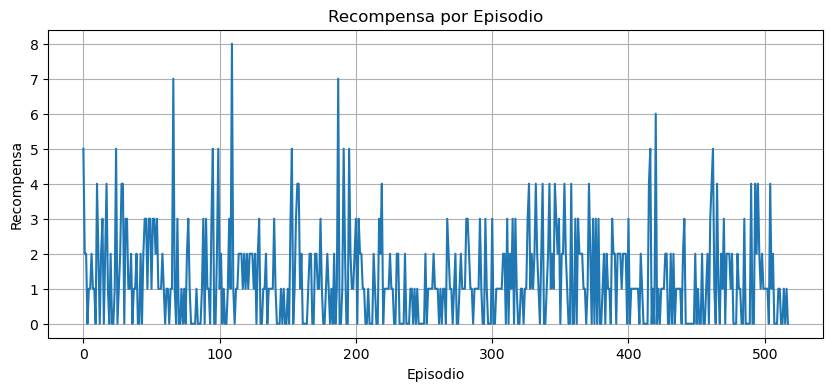

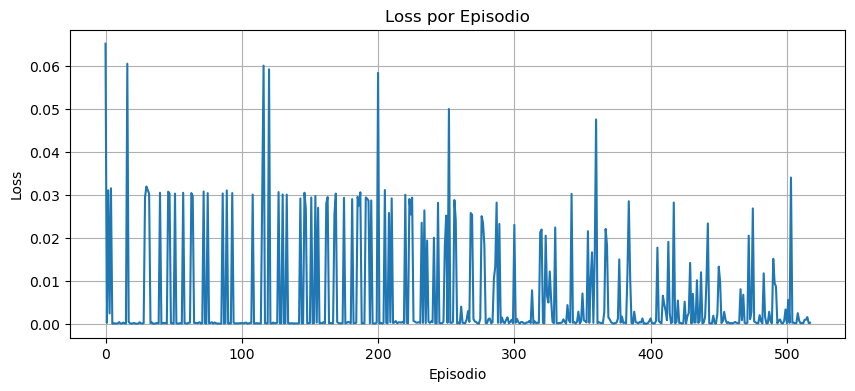

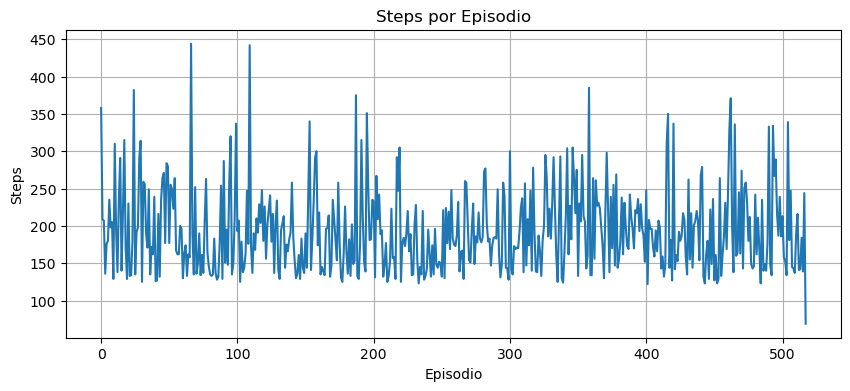

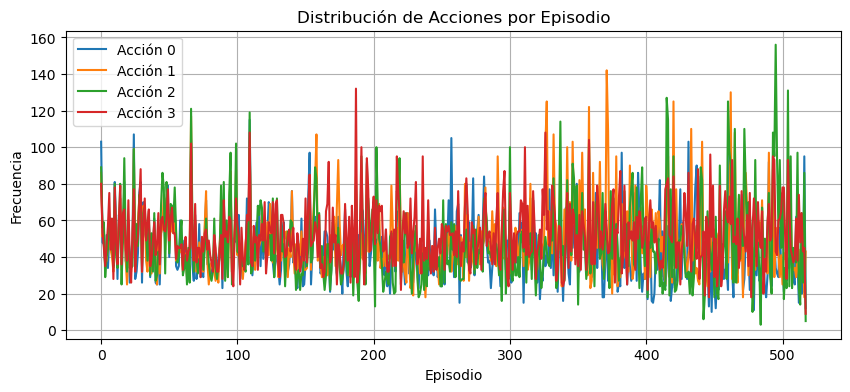

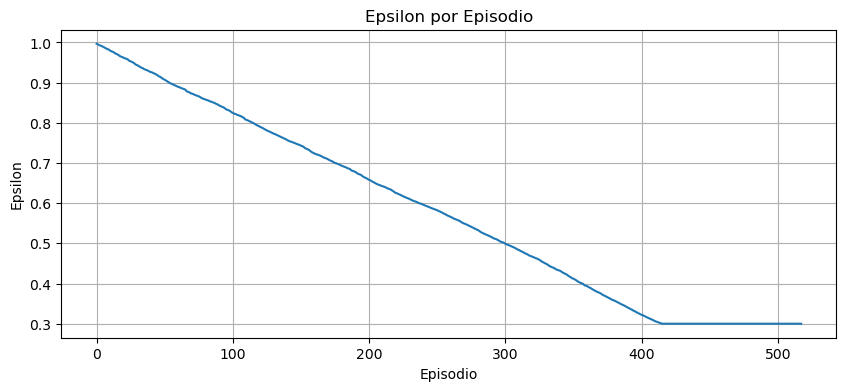

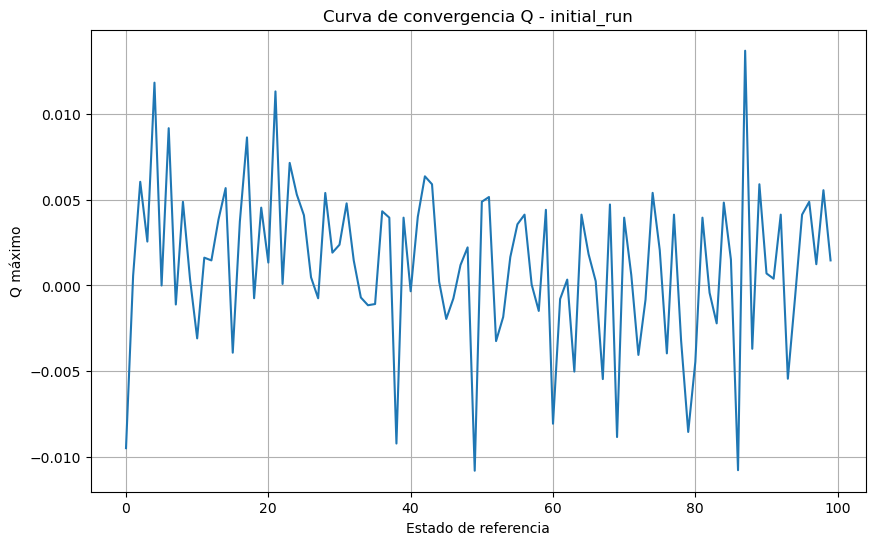

In [48]:
evaluate_training_phase_results("metrics/ddqn/metrics_initial_run.npz", "initial_run")

## 3. Fase 2 de entrenamiento: Aprendizaje básico

Después de la primera etapa de exploración, el enfoque en esta fase no es tanto seguir descubriendo, sino empezar a pulir. El agente ya tiene una idea básica de cómo funciona el entorno, por lo que ahora buscamos que sus decisiones sean menos impulsivas y más fundamentadas.

A diferencia del entrenamiento con DQN, donde a veces se tienden a sobrevalorar ciertas acciones, en esta etapa implementamos Double DQN. Esto mejora la estabilidad del aprendizaje al separar la acción que se elige de la acción que se evalúa, lo que reduce errores comunes al calcular los valores Q.

Para este bloque usamos **500.000 pasos** y ajustamos epsilon para que el agente aún explore, pero cada vez con más intención de explotar lo que ya aprendió. No se trata de tomar riesgos porque sí, sino de afinar su comportamiento usando la experiencia que va acumulando.

En este punto, ya no esperamos saltos grandes en la recompensa de un momento a otro. Más bien, buscamos señales de consistencia: que el agente repita buenos comportamientos, que sobreviva más tiempo y que el loss empiece a estabilizarse. La mejora puede parecer más lenta, pero es justamente el signo de que está aprendiendo de verdad.

- `EPSILON_INI = 0.3`
- `EPSILON_MIN = 0.05`
- `EPSILON_ANNEAL_STEPS = 300_000`

In [53]:
execute_ddqn_training_phase("phase_2", total_steps=500_000, episodes=EPISODES, epsilon_ini=0.3, epsilon_min=0.05, epsilon_anneal_steps=300_000, load_net_path="net_history/ddqn/GenericDDQNAgent-run:initial_run_final.dat")

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -1811653209
Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]

Iniciando entrenamiento...


/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:  16%|█▋        | 1639/10000 [1:55:16<9:48:01,  4.22s/episode, reward=1.5, epsilon=0.05, steps=5e+5]      

Entrenamiento detenido: se alcanzaron 500001 pasos.
Checkpoint guardado en GenericDQNAgent-steps:500001-e:0.05.dat



/var/folders/lz/2270s0896n93xmtl9tmd6g080000gq/T/ipykernel_86674/3359167941.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Datos cargados de metrics/ddqn/metrics_phase_2.npz: [[ 62  38  50  61]
 [ 37  11  19  88]
 [ 46  15 105  95]
 ...
 [111  13 174  89]
 [113  83 147  98]
 [  3   0   7  12]]


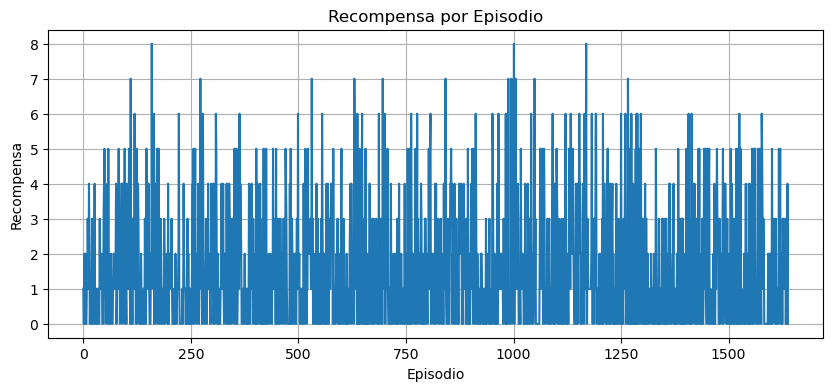

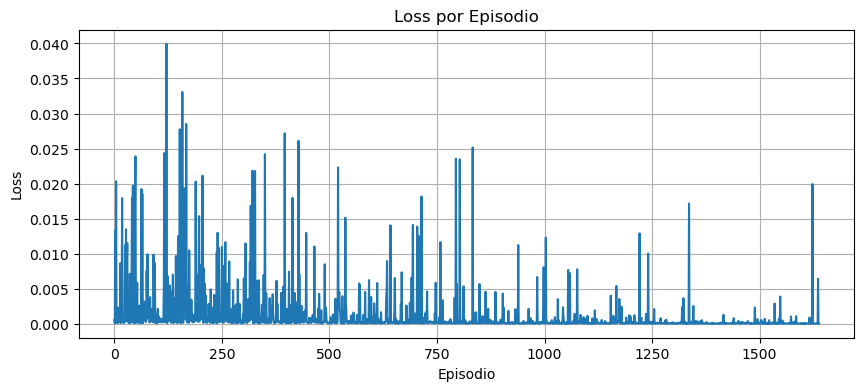

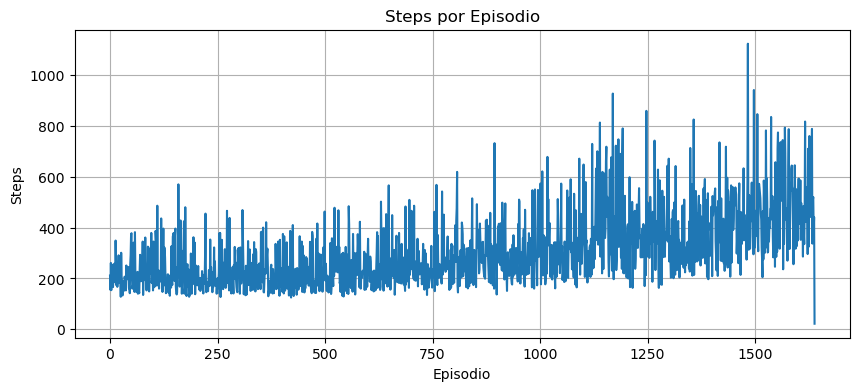

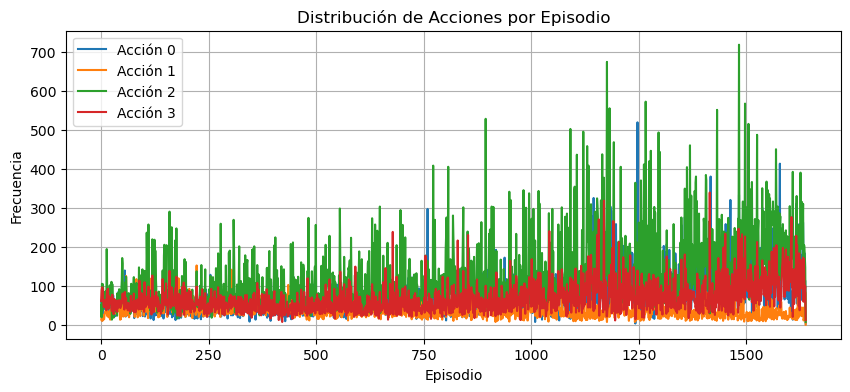

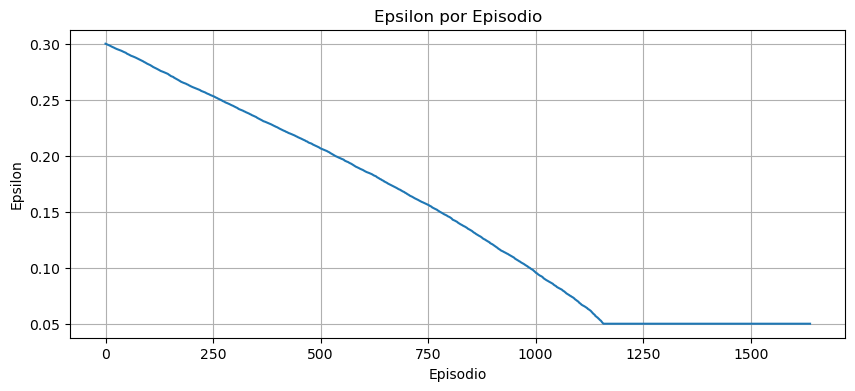

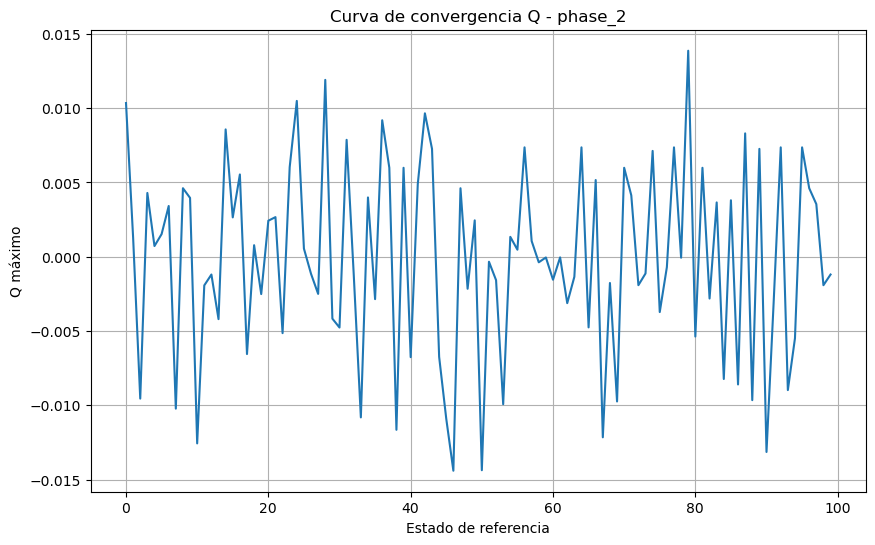

In [54]:
evaluate_training_phase_results("metrics/ddqn/metrics_phase_2.npz", "phase_2")

## 4. Fase 3: Consolidación y estabilidad de la política

- `EPSILON_INI = 0.1`: partimos de una exploración baja, porque el agente ya tiene una base aprendida.
- `EPSILON_MIN = 0.01`: dejamos una pequeña ventana de exploración por si aún puede descubrir mejores acciones.
- `EPSILON_ANNEAL_STEPS = 1.000.000`: el `epsilon` decae lentamente, permitiendo una transición gradual hacia la explotación.

In [55]:
execute_ddqn_training_phase("phase_3", total_steps=2_000_000, episodes=EPISODES, epsilon_ini=0.1, epsilon_min=0.01, epsilon_anneal_steps=1_000_000, load_net_path="net_history/ddqn/GenericDDQNAgent-run:phase_2_final.dat")

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -1893007300
Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]

Iniciando entrenamiento...


/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:  13%|█▎        | 1329/10000 [1:58:41<17:31:06,  7.27s/episode, reward=1.14, epsilon=0.055, steps=5e+5]   

Checkpoint guardado en GenericDQNAgent-steps:500257-e:0.054976870000000004.dat


Entrenando:  21%|██        | 2068/10000 [3:49:29<46:08:59, 20.95s/episode, reward=1.49, epsilon=0.01, steps=1e+6]    

Checkpoint guardado en GenericDQNAgent-steps:1001127-e:0.01.dat


Entrenando:  24%|██▍       | 2411/10000 [5:42:24<48:12:31, 22.87s/episode, reward=1.95, epsilon=0.01, steps=1.5e+6] 

Checkpoint guardado en GenericDQNAgent-steps:1500742-e:0.01.dat


Entrenando:  27%|██▋       | 2725/10000 [7:33:20<20:10:17,  9.98s/episode, reward=1.54, epsilon=0.01, steps=2e+6]   

Entrenamiento detenido: se alcanzaron 2000001 pasos.
Checkpoint guardado en GenericDQNAgent-steps:2000001-e:0.01.dat



/var/folders/lz/2270s0896n93xmtl9tmd6g080000gq/T/ipykernel_86674/3359167941.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Datos cargados de metrics/ddqn/metrics_phase_3.npz: [[  63   17  147   59]
 [ 108    7  154   41]
 [ 168   12  270   61]
 ...
 [1115   53  364  100]
 [1099   80  402  122]
 [ 761    5  334  110]]


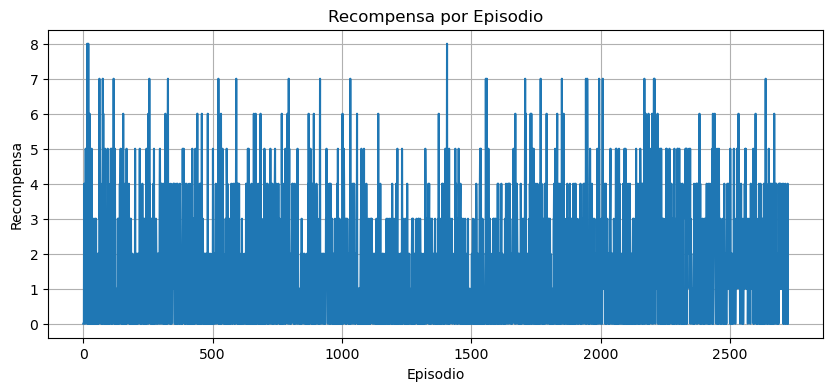

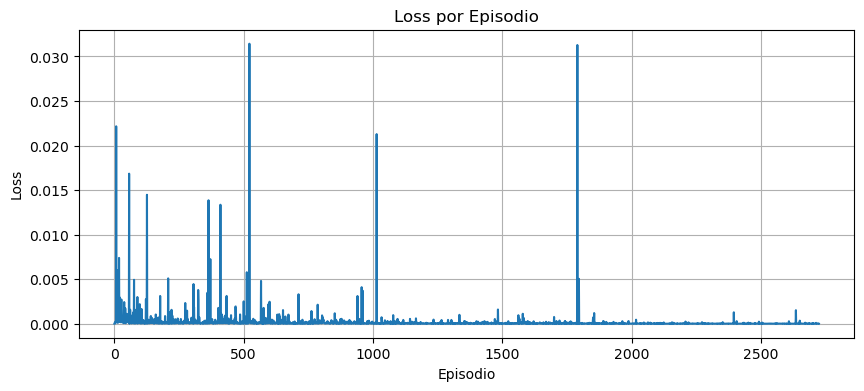

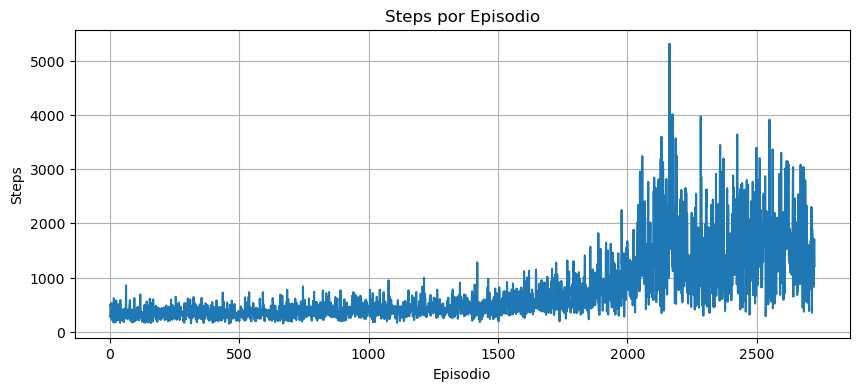

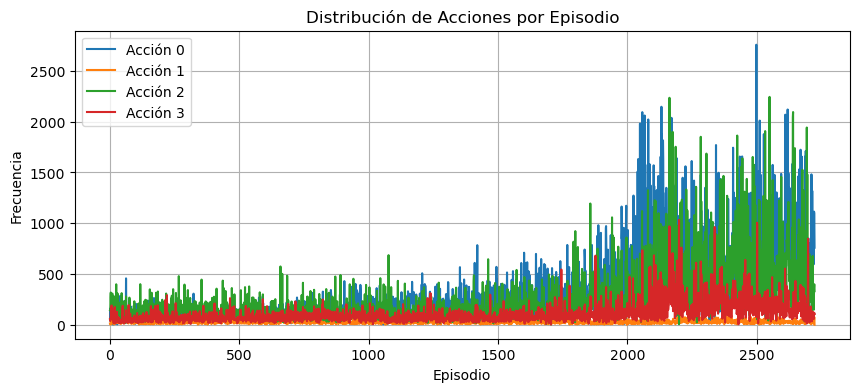

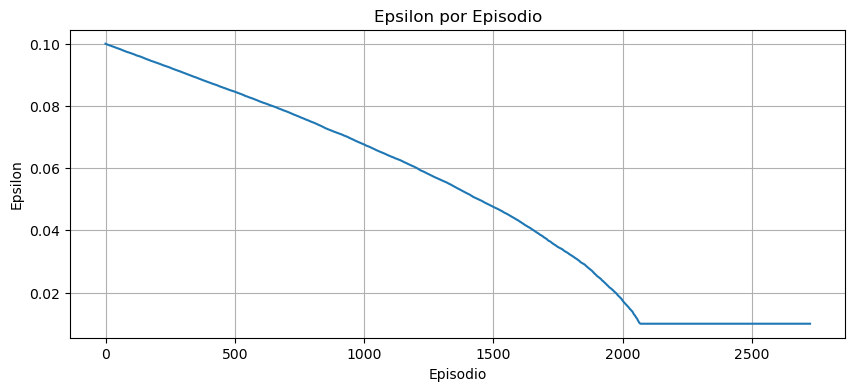

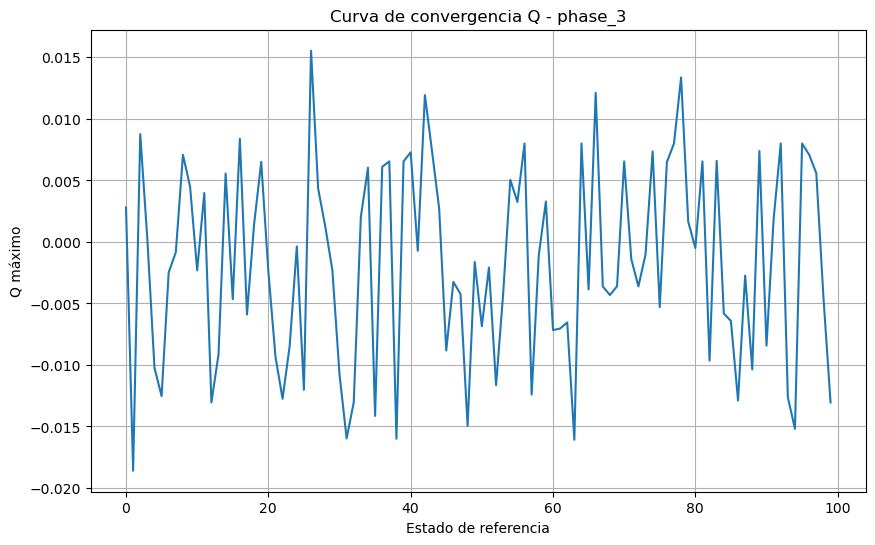

In [56]:
evaluate_training_phase_results("metrics/ddqn/metrics_phase_3.npz", "phase_3")

## 5. Entrenamiento largo

Se van a ejecutar **7.000.000** de pasos dividos en 1 fase de **1.000.000.** de pasos y 3 fases una de **2.000.000** de pasos 

Mantenemos un valor inicial muy bajo para promover una política estable, pero sin eliminar por completo la posibilidad de explorar si se presenta algo poco frecuente:

- `EPSILON_INI = 0.05`: el agente comienza confiando casi por completo en su política aprendida.
- `EPSILON_MIN = 0.01`: se conserva un margen muy pequeño de exploración para evitar caer en políticas rígidas o locales.
- `EPSILON_ANNEAL_STEPS = 1.000.000`: el descenso es lento y progresivo, asegurando una transición estable hacia la explotación total.


In [58]:
execute_ddqn_training_phase("phase_4_1", total_steps=1_000_000, episodes=EPISODES, epsilon_ini=0.05, epsilon_min=0.01, epsilon_anneal_steps=1_000_000, load_net_path="net_history/ddqn/GenericDDQNAgent-run:phase_3_final.dat")

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 492267392
Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]

Iniciando entrenamiento...


/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:  18%|█▊        | 1755/10000 [2:12:43<9:26:13,  4.12s/episode, reward=1.06, epsilon=0.03, steps=5e+5]     

Checkpoint guardado en GenericDQNAgent-steps:500115-e:0.029995400000000002.dat


Entrenando:  39%|███▊      | 3854/10000 [4:29:50<7:10:19,  4.20s/episode, reward=1.14, epsilon=0.01, steps=1e+6]     

Entrenamiento detenido: se alcanzaron 1000001 pasos.
Checkpoint guardado en GenericDQNAgent-steps:1000001-e:0.01.dat



/var/folders/lz/2270s0896n93xmtl9tmd6g080000gq/T/ipykernel_86674/3359167941.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Datos cargados de metrics/ddqn/metrics_phase_4_1.npz: [[166  13 286  60]
 [184  36  92  47]
 [  4  86  64   4]
 ...
 [ 49 118  27  34]
 [ 28  97   0   0]
 [ 69  20   8  10]]


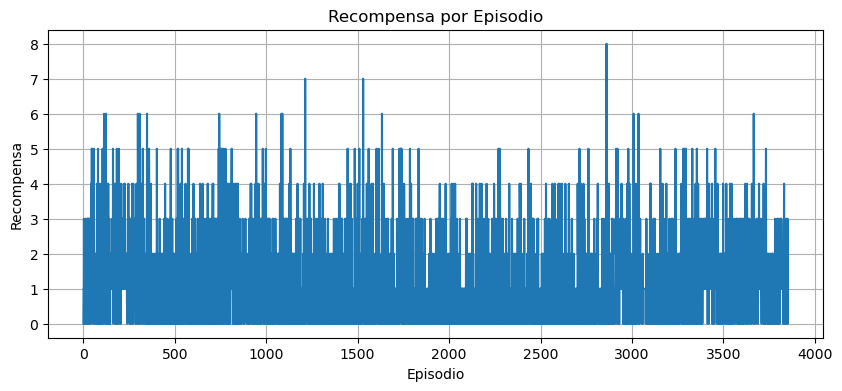

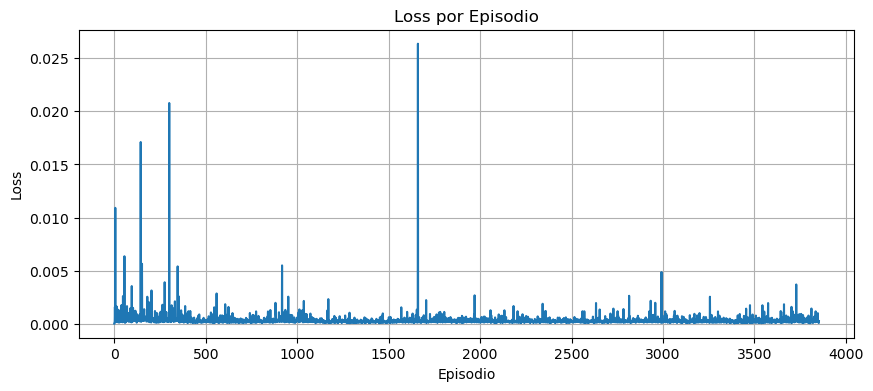

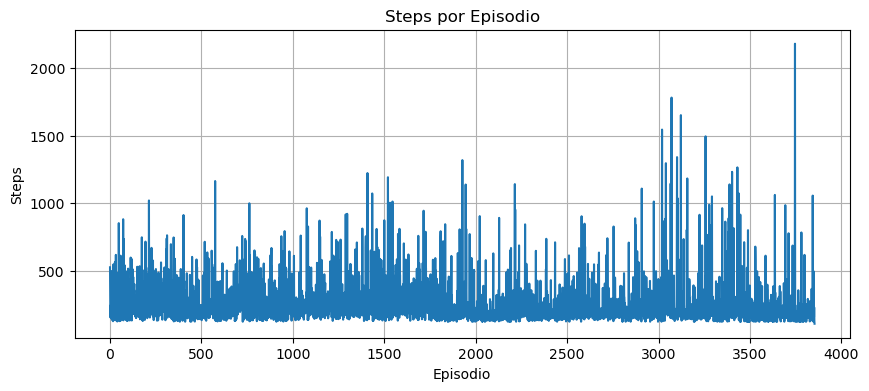

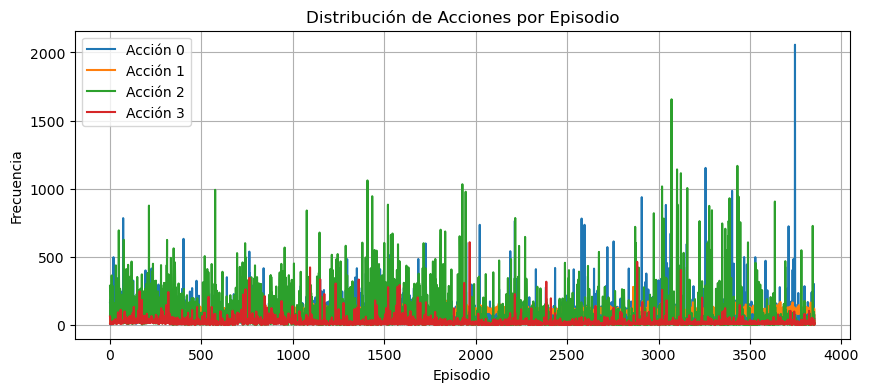

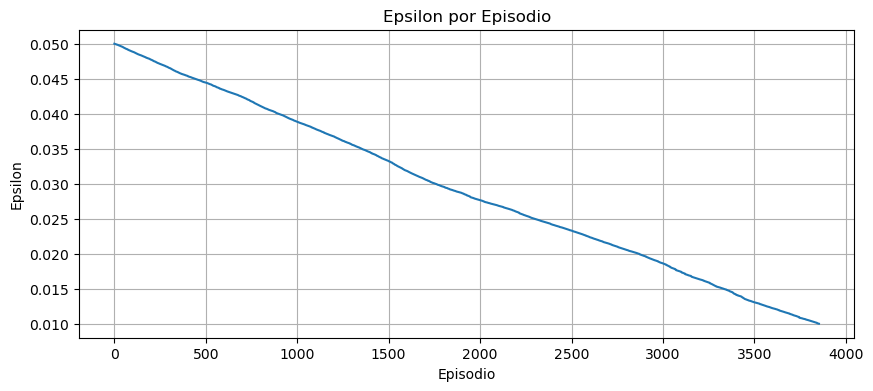

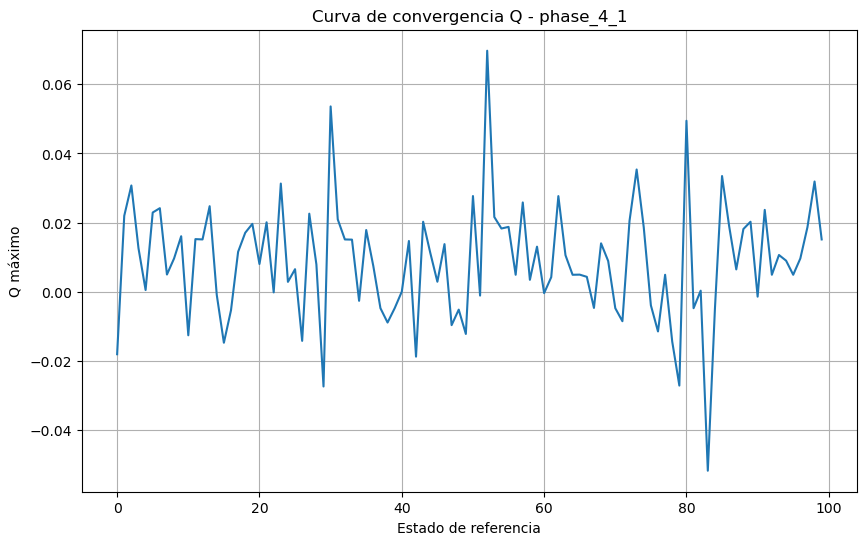

In [59]:
evaluate_training_phase_results("metrics/ddqn/metrics_phase_4_1.npz", "phase_4_1")

In [67]:
execute_ddqn_training_phase("phase_4_1", total_steps=1_000_000, episodes=EPISODES, epsilon_ini=0.01, epsilon_min=0.01, epsilon_anneal_steps=1_000_000, load_net_path="net_history/ddqn/GenericDDQNAgent-run:phase_4_1_final.dat", play=True)

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 975133690


### Entrenamos

In [1]:
from double_dqn_agent import DoubleDQNAgent

env = make_env(ENV_NAME,
                video_folder='./videos/ddqn_training',
                name_prefix="breakout",
                record_every=500,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )


modelo_a = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)
modelo_b = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)

ddqn_agent = DoubleDQNAgent(env, modelo_a, modelo_b, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i= EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_steps=EPSILON_ANNEAL_STEPS, episode_block = EPISODE_BLOCK, device=DEVICE)

ddqn_rewards = ddqn_agent.train(EPISODES, STEPS_PER_EPISODE, TOTAL_STEPS)

KeyboardInterrupt: 

In [ ]:
env = make_env(ENV_NAME,
                video_folder='./videos/ddqn_validation',
                name_prefix="breakout",
                record_every=1,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

ddqn_agent.play(env, episodes=3)

env.close()

In [ ]:
# Ruta al archivo de vídeo en tu sistema de ficheros
video_path = "./videos/ddqn_validation/breakout-episode-0.mp4"

# Muestra el vídeo
Video(video_path, embed=True, width=600)

#### Graficas 
...

# Experimentación
Aquí con libertad total, pueden probar diferentes arquitecturas de red, diferentes hiperparámetros, diferentes técnicas de exploración, etc.
...

# Comparaciones, Resultados, Comentarios...
De aquí en adelante son libres de presentar como gusten los resultados comparativos de las técnicas.
...